In [1]:
import sys
sys.path.append("../src")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from exact_solution import solve_master_equation, one_excited_emitter_state

In [2]:
aqt_results = pd.read_csv("../data/AQT/QMarina-AQT-4Q.csv", index_col=0)
aqt_results = aqt_results.set_index(["Time", "Protocol", "Randomizations", "Identities"])

aqt_bitstrs = {
    "Emitter 1": "1000",
    "Emitter 2": "0100",
    "Emitter 3": "0001",
    "Cavity + Environment": "0010",
}

In [3]:
N = 3
g = 4
kappa = 2
times = np.linspace(0, 3, 101)

In [4]:
initial_state = one_excited_emitter_state(N, 1)
qutip_results = solve_master_equation(N, g, kappa, initial_state, times)

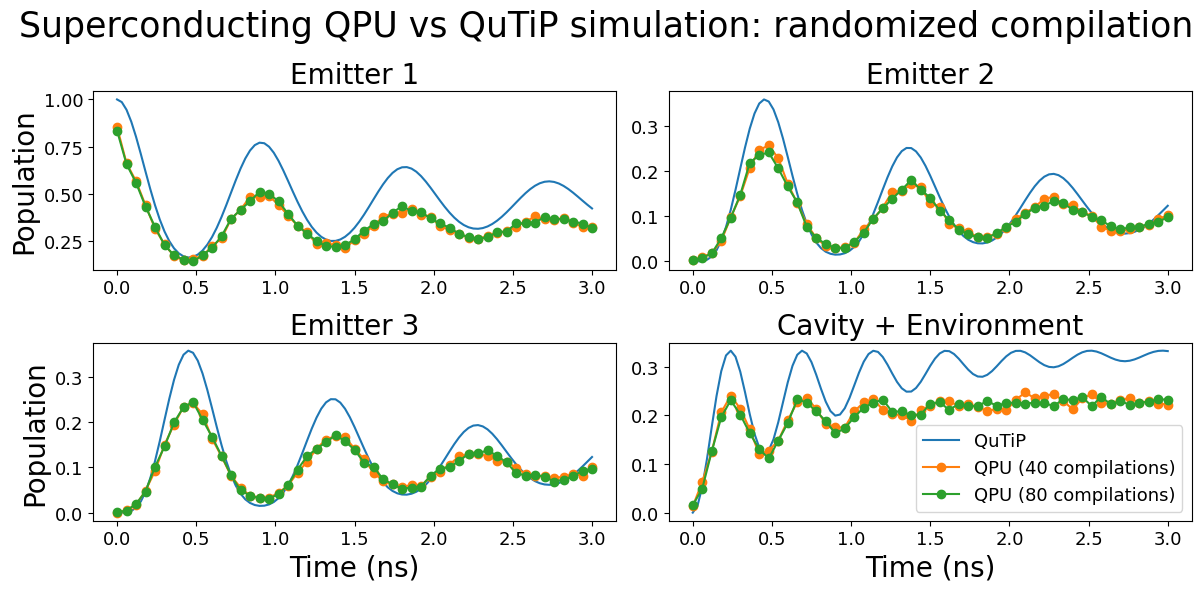

In [5]:
# Plot the RC data
fig, axes = plt.subplots(2, 2, figsize=(12, 6))

for a, column in zip(axes.flatten(), qutip_results.columns):
    a.set_title(column, fontsize=20)
    a.plot(qutip_results.index, qutip_results[column], label="QuTiP")

    for rands in [40, 80]:
        aqt_rc = aqt_results.xs("RC", level="Protocol").xs(rands, level="Randomizations")
        times = aqt_rc.index.get_level_values("Time")
        aqt_column = aqt_bitstrs[column]
        a.plot(times, aqt_rc[aqt_column], marker='o', label=f"QPU ({rands} compilations)")

    a.tick_params(axis='x', labelsize=13)
    a.tick_params(axis='y', labelsize=13)

axes[1][0].set_xlabel("Time (ns)", fontsize=20)
axes[1][1].set_xlabel("Time (ns)", fontsize=20)

axes[0][0].set_ylabel("Population", fontsize=20)
axes[1][0].set_ylabel("Population", fontsize=20)

axes[1][1].legend(fontsize=13)

fig.suptitle("Superconducting QPU vs QuTiP simulation: randomized compilation", fontsize=25)
plt.tight_layout()


In [6]:
fig.savefig("../figures/AQT_RC.eps")